# JAX Implementation of Gaussian VAE

In this notebook, we implemented a VAE where both the encoder and decoder model gaussian distributions. The model is trained on CelebA 64x64.

This implementation is in JAX.

For Tensorflow and Pytorch implementations, check the other notebooks.

In [ ]:
import tensorflow as tf
import os
from tqdm import tqdm

# Prevent tensorflow from using GPUs
tf.config.set_visible_devices([], device_type='GPU')

2025-01-05 18:00:58.686400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736096458.703627  656630 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736096458.708869  656630 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 18:00:58.726783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from ilms.models.celeba_vae import VAEModel

In [3]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from clu import parameter_overview
import distrax
from time import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
import orbax.checkpoint as ocp
from flax.training import train_state
import optax
from flax.training import orbax_utils

import warnings

## Run Hyperparams

Define the training params.

`WARMUP_STEPS` defines the number of training updates over which we do a linear learning rate warmup. We found that such a learning rate warmup is very useful for model stability in the early stages of training.

`ENCODER_CONV_UNITS` and `DECODER_CONV_UNITS` are lists of lists. The outer list is a list of layers. Each layer is defined as a list of `[channels, kernel_size, stride, activation, name]`.

`ENCODER_DENSE_UNITS` and `DECODER_DENSE_UNITS` are lists of lists. The outer list is a list of layers. Each layer is defined as a list of `[channels, activation, name]`.

In [4]:
# RNG params
GLOBAL_KEY = random.key(2409)

# Data params
INPUT_SHAPE = (64,64,3)

# Training params
BATCH_SIZE = 64
TOTAL_TRAINING_STEPS = 200000
EVAL_EVERY_N_STEPS = 2000
VALIDATION_STEPS = 50

# Optimizer params
INITIAL_LEARNING_RATE = 1e-3
DECAY_STEPS = 50000
DECAY_RATE = 0.5
WARMUP_STEPS = 1000

## Data processing

In [5]:
from ilms.data import CelebAIterator, create_pipeline
from nvidia.dali.plugin.jax import DALIGenericIterator
train_src = CelebAIterator(BATCH_SIZE, 'train')
val_src = CelebAIterator(BATCH_SIZE, 'val')

train_pipeline = create_pipeline(BATCH_SIZE, train_src)

val_pipeline = create_pipeline(BATCH_SIZE, val_src)

train_pipeline.build()
val_pipeline.build()



train_dataset = DALIGenericIterator([train_pipeline], ['image'])
val_dataset = DALIGenericIterator([val_pipeline], ['image'])

Found 162770 images in train set
Found 19867 images in val set


## Definining loss

For the Loss, we use the `Negative ELBO = -likelihood + KL_div`.

- `likelihood = decoder_dist.log_pdf(targets)`
- `KL_div = KL(posterior_dist || prior_dist)`
- The `posterior_dist` is the encoder distribution.
- For simplicity, we set the prior distribution to be a simple standard Gaussian `N(0, 1)`.

To help the model avoid a posterior collapse, we warmup the `KL_div` by linearly scaling it up over 10000 steps.

In [8]:
from ilms.losses import NelboLoss

## Defining model

In [9]:
model = VAEModel(64, INPUT_SHAPE)

In [10]:
model.batch_size

64

In [11]:
# Initialize the mode weights using a dummy input
training_key, generation_key, x_key, init_key = random.split(GLOBAL_KEY, 4)
x = random.normal(x_key, (BATCH_SIZE, *INPUT_SHAPE))
params = model.init(init_key, init_key, x)

print(parameter_overview.get_parameter_overview(params))

2025-01-05 18:01:38.227549: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-05 18:01:38.440338: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-05 18:01:38.440384: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


+-----------------------------------------------+------------------+---------+-----------+-----------+---------+
| Name                                          | Shape            | Dtype   | Size      | Mean      | Std     |
+-----------------------------------------------+------------------+---------+-----------+-----------+---------+
| params/decoder_convs/convs_list_0/conv/bias   | (256,)           | float32 | 256       | 0.0       | 0.0     |
| params/decoder_convs/convs_list_0/conv/kernel | (4, 4, 256, 256) | float32 | 1,048,576 | -7.87e-06 | 0.0156  |
| params/decoder_convs/convs_list_2/conv/bias   | (256,)           | float32 | 256       | 0.0       | 0.0     |
| params/decoder_convs/convs_list_2/conv/kernel | (4, 4, 256, 256) | float32 | 1,048,576 | -1.22e-06 | 0.0156  |
| params/decoder_convs/convs_list_4/conv/bias   | (256,)           | float32 | 256       | 0.0       | 0.0     |
| params/decoder_convs/convs_list_4/conv/kernel | (4, 4, 256, 256) | float32 | 1,048,576 | 3.26e

## utility functions for training

Saving and Loading checkpoints

In [12]:


def create_checkpoint_manager(checkpoint_path, max_allowed_checkpoints=2):
    options =ocp.CheckpointManagerOptions(max_to_keep=max_allowed_checkpoints, create=True)
    return ocp.CheckpointManager(
        os.path.abspath(checkpoint_path),ocp.Checkpointer(ocp.PyTreeCheckpointHandler()), options = options)


def save_checkpoint(checkpoint_manager, step, state):
    ckpt = {'state': state, 'step': step}
    save_args = orbax_utils.save_args_from_target(ckpt)
    
    checkpoint_manager.save(step, ckpt, save_kwargs={'save_args': save_args})


def load_checkpoint_if_exists(checkpoint_manager,state):
    if checkpoint_manager.latest_step() is not None:
        print(f"Loading checkpoint state for step {checkpoint_manager.latest_step()} from {checkpoint_manager._directory}")
        step = checkpoint_manager.latest_step()
        target = {'state': state, 'step': 0}
        ckpt = checkpoint_manager.restore(step, items=target)
        
        return ckpt['step'], ckpt['state']

    print(f"Couldn't find state checkpoints to load in {checkpoint_manager._directory}!!")
    return 0, state

Metrics book keeping and plotting utilities

In [13]:
def plot_samples(tdec_mean, tdec_logstd, ttargets, vdec_mean, vdec_logstd, vtargets, key):
    keys = random.split(key, num=4)
    _, axes = plt.subplots(1,8,figsize=(8,4))
    axes[0].imshow(ttargets[0])
    axes[1].imshow(distrax.Normal(tdec_mean[0],tf.math.exp(tdec_logstd[0])).sample(seed=keys[0]))
    axes[2].imshow(ttargets[1])
    axes[3].imshow(distrax.Normal(tdec_mean[1],tf.math.exp(tdec_logstd[1])).sample(seed=keys[1]))
    axes[4].imshow(vtargets[0])
    axes[5].imshow(distrax.Normal(vdec_mean[0],tf.math.exp(vdec_logstd[0])).sample(seed=keys[2]))
    axes[6].imshow(vtargets[1])
    axes[7].imshow(distrax.Normal(vdec_mean[1],tf.math.exp(vdec_logstd[1])).sample(seed=keys[3]))
    plt.tight_layout(pad=-2.)
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show() 

# Updates dictionary that stores changes in loss values
def get_results(results, losses):
    for i,key in enumerate(results.keys()):
        results[key].append(losses[i])

Learning rate schedule utility

Training loop utilities

In [14]:
def forward(params, inputs, targets, step, key):
    """
    Forward function of the neural network (inputs -> model -> outputs -> loss).
    Created to call jax.grad on this function and do automatic differentiation for backprop.
    """
    enc_mean, enc_logstd, dec_mean, dec_logstd = model.apply({'params': params}, key, inputs)
    loss_value, rec, kl = loss(dec_mean, dec_logstd, enc_mean, enc_logstd, targets, step)
    return loss_value, (rec, kl)

@jit
def train_step(inputs, targets, step,state, key):
    """
    Train step. XLA compiled
    """
    (nelbo,(rec, kl)), grads = jax.value_and_grad(forward, has_aux=True)(state.params, inputs, targets, step, key)
    state = state.apply_gradients(grads=grads)
    return nelbo, rec, kl, state

@jit
def val_step(inputs, targets, step, params, key):
    """
    Val step. XLA compiled
    """
    enc_mean, enc_logstd, dec_mean, dec_logstd = model.apply({'params': params}, key, inputs)
    loss_value, rec, kl = loss(dec_mean, dec_logstd, enc_mean, enc_logstd, targets, step)
    return loss_value, rec, kl, dec_mean, dec_logstd

def validate(dataset, step, params, key):
    """
    Validation loop. 
    """
    avg_loss = 0.
    avg_rec = 0.
    avg_kl = 0.
    for v_step, (BATCH_SIZE) in zip(range(VALIDATION_STEPS), dataset):
        key, model_key = random.split(key) 
        inputs, targets = BATCH_SIZE['image'], BATCH_SIZE['image']
        loss_value, rec, kl, dec_mean, dec_logstd = val_step(inputs, targets, step, params, model_key)
        avg_loss += loss_value
        avg_rec += rec
        avg_kl += kl       
        
    avg_loss /= (v_step + 1)
    avg_rec /= (v_step + 1)
    avg_kl /= (v_step + 1) 
    
    return avg_loss, avg_rec, avg_kl, dec_mean[:2], dec_logstd[:2], targets[:2]
    

def validate_and_plot(train_dataset, val_dataset, step, params, key):
    """
    Validation function for both train and val data + metrics and artifacts logging.
    """
    tkey, vkey, plot_key = random.split(key, num=3)
    tavg_loss, tavg_rec, tavg_kl, tdec_mean, tdec_logstd, ttargets = validate(train_dataset, step, params, tkey)
    vavg_loss, vavg_rec, vavg_kl, vdec_mean, vdec_logstd, vtargets = validate(val_dataset, step, params, vkey)
    
    print(f"\nstep {step}/{TOTAL_TRAINING_STEPS}  train_loss:  nelbo:{tavg_loss:.4f}  rec:{tavg_rec:.4f}  kl:{tavg_kl:.4f}      "
          f"val_loss:  nelbo:{vavg_loss:.4f}  rec:{vavg_rec:.4f}  kl:{vavg_kl:.4f}")
    plot_samples(tdec_mean, tdec_logstd, ttargets, vdec_mean, vdec_logstd, vtargets, plot_key)

    return tavg_loss, tavg_rec, tavg_kl, vavg_loss, vavg_rec, vavg_kl

def train(train_dataset, val_dataset, results, state, key):
    """
    Training loop
    """
    # Restore model if resuming training
    initial_step, state = load_checkpoint_if_exists(checkpoint_manager, state)

    pbar = tf.keras.utils.Progbar(EVAL_EVERY_N_STEPS, stateful_metrics=['nelbo','rec','kl'])

    for step, batch in tqdm(zip(range(initial_step, TOTAL_TRAINING_STEPS+1),train_dataset)):
        key, model_key = random.split(key) 
        inputs, targets = batch['image'], batch['image']
        nelbo, rec, kl, state = train_step(inputs, targets, step, state, model_key) 
        pbar.update(step % EVAL_EVERY_N_STEPS, [('nelbo', nelbo),('rec', rec),('kl', kl)])
                    
        if step % EVAL_EVERY_N_STEPS == 0:
            losses = validate_and_plot(train_dataset, val_dataset, step, state.params, key)
            # update the results dict with latest metrics
            get_results(results, losses)

            # Save new model checkpoint
            save_checkpoint(checkpoint_manager, step, state)
            print(f'SAVED CHECKPOINT FOR STEP {step}..')

## Model training

In [15]:
# Define this run's model name
MODEL_NAME = 'vae_celeba64_dense256'

loss = NelboLoss(BATCH_SIZE)

lr_schedule = optax.warmup_exponential_decay_schedule(init_value=0, peak_value=INITIAL_LEARNING_RATE, 
                                                    warmup_steps=WARMUP_STEPS, 
                                                    transition_steps=DECAY_STEPS, 
                                                    decay_rate=DECAY_RATE)
optimizer = optax.adamax(lr_schedule)
state = train_state.TrainState.create(apply_fn=model.apply, params=params['params'], tx=optimizer)
checkpoint_manager = create_checkpoint_manager(checkpoint_path=f'jax_checkpoints2/{MODEL_NAME}')

Couldn't find state checkpoints to load in /home/stasy/work1/identifiable/jax_checkpoints2/vae_celeba64_dense256!!


2025-01-05 18:01:44.054429: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-05 18:01:44.272872: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-05 18:01:44.272917: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-05 18:01:46.705242: W external/xla/xla/tsl/framework/bfc_allocato

   0/2000 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - nelbo: 1.0935 - rec: 1.0935 - kl: 0.0000e+00

2025-01-05 18:01:57.724365: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-01-05 18:01:57.942227: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



step 0/200000  train_loss:  nelbo:1.1004  rec:1.1004  kl:0.0000      val_loss:  nelbo:1.0972  rec:1.0972  kl:0.0000


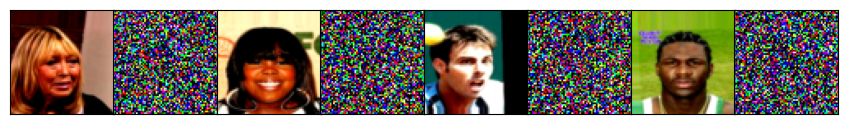

SAVED CHECKPOINT FOR STEP 0..
 156/2000 ━━━━━━━━━━━━━━━━━━━━ 5:36 182ms/step - nelbo: 0.3385 - rec: 0.3383 - kl: 1.6067e-04

KeyboardInterrupt: 

In [16]:
results = {'nelbo':[],'rec':[],'kl':[],'val_nelbo':[],'val_rec':[],'val_kl':[]}
start_time=time()
train(train_dataset, val_dataset, results,state, training_key)
end_time=time()
print(f'Total time for {TOTAL_TRAINING_STEPS} is {end_time-start_time:.2f}s')

plot the loss curves

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].plot(results['nelbo'][1:], color='teal', label='nelbo')
axes[0].plot(results['val_nelbo'][1:], color='orange', label='val_nelbo')
axes[0].set_title('Nelbo loss', fontsize=20)
axes[0].legend(loc="upper left")

axes[1].plot(results['rec'][1:], color='teal', label='rec')
axes[1].plot(results['val_rec'][1:], color='orange', label='val_rec')
axes[1].set_title('Reconstruction loss', fontsize=20)
axes[1].legend(loc="upper left")

axes[2].plot(results['kl'][1:], color='teal', label='kl')
axes[2].plot(results['val_kl'][1:], color='orange', label='val_kl')
axes[2].set_title('KL loss', fontsize=20)
axes[2].legend(loc="upper left")

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

## Model Generation

In this section, we generate new images from the prior distribution

In [17]:
# choose the model to generate from
MODEL_NAME = 'vae_celeba64_dense256'

# initialize the mode weights using a dummy input
training_key, generation_key, x_key, init_key = random.split(GLOBAL_KEY, 4)
x = random.normal(x_key, (BATCH_SIZE, *INPUT_SHAPE))
params = model.init(init_key, init_key, x)

loss = NelboLoss()
lr_schedule = optax.warmup_exponential_decay_schedule(init_value=0, peak_value=INITIAL_LEARNING_RATE, 
                                                    warmup_steps=WARMUP_STEPS, 
                                                    transition_steps=DECAY_STEPS, 
                                                    decay_rate=DECAY_RATE)
optimizer = optax.adamax(lr_schedule)
opt_state = optimizer.init(params['params'])

# Load model checkpoint
checkpoint_manager = create_checkpoint_manager(checkpoint_path=f'jax_checkpoints/{MODEL_NAME}')
initial_step, params, opt_state = load_checkpoint_if_exists(checkpoint_manager, params, opt_state)

Loading checkpoint state for step 2000 from /home/rayhane/JocaProjects/celeba_vae/jax_checkpoints/vae_celeba64_dense256


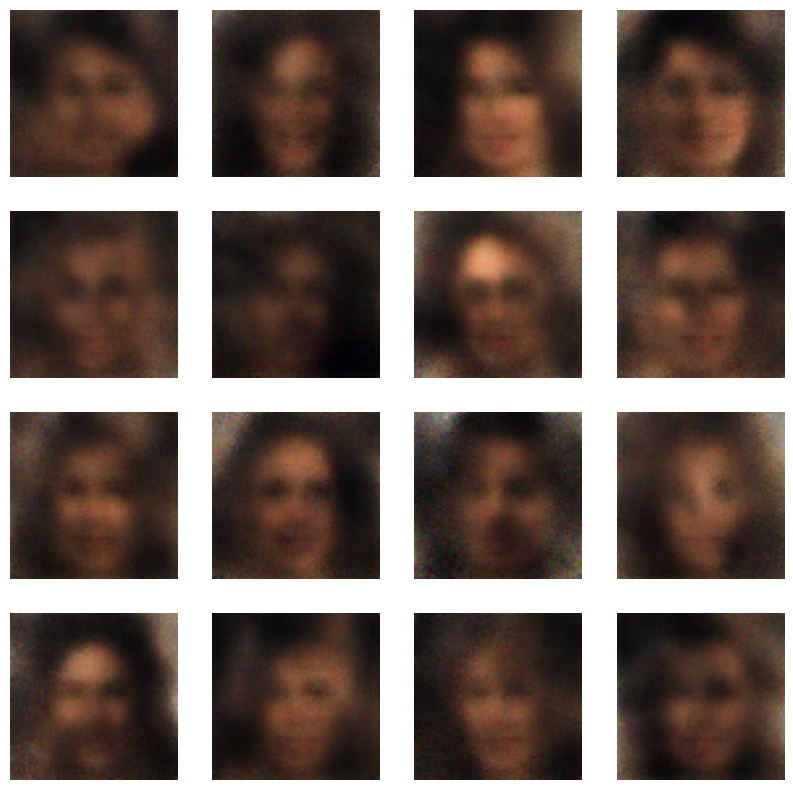

In [18]:
# Pick encoder distribution temperature (z_temp) and decoder distribution temperature (x_temp)
# Generate from the prior
generation_key, key = random.split(generation_key)
pictures = model.apply({'params': params}, key, 1., 0.3, method=model.generate)

# Plot grid of generated pictures
fig, axes32 = plt.subplots(4,4, figsize=(10,10))
for i, axes8 in enumerate(axes32):
    for j, ax in enumerate(axes8):
        index = i * axes32.shape[1] + j
        ax.imshow(pictures[index])
        ax.axis('off')
plt.show()